# Probabilistic Forecasting Model to Predict Air Pollution Days

- Dataset: [Ozone Level Detection UCI](https://archive.ics.uci.edu/ml/datasets/ozone+level+detection)
- Research paper: [Forecasting Skewed Biased Stochastic Ozone Days: Analyses and Solutions](https://sci-hub.do/https://doi.org/10.1109/ICDM.2006.73)

This project is inspired by Jason Brownlee's [article](https://machinelearningmastery.com/how-to-develop-a-probabilistic-forecasting-model-to-predict-air-pollution-days/)


Hyndman and Athanasopoulos in their book Forecasting: principles and practice, introducing The 5 basic steps in a forecasting task. Those steps are:
## 1. Problem definition: 
Air pollution can be characterized as a high measure of ozone at the ground level, often characterized as “bad ozone” to differentiate it from the ozone in the higher atmosphere. As a time series classification prediction problem, the ozone prediction problem asks whether the next day will be a high air pollution day (ozone day). Using ozone day predictions can enable meteorological organizations to inform the public so that they can take precautions.
## 2. Gathering information: 
The dataset was originally studied by Kun Zhang, et al. in their 2006 paper “Forecasting Skewed Biased Stochastic Ozone Days: Analyses and Solutions”. The dataset contains seven years of daily observations of meteorological variables (1998-2004 or 2,536 days) and whether there was an ozone day or not, taken in the Houston, Galveston, and Brazoria areas, Texas, USA. A total of 72 variables were observed each day, many of which are believed to be relevant to the prediction problem, and 10 of which have been confirmed to be relevant based on the physics.
## 3. Preliminary Exploratory Analysis: 
As presented below

In [1]:
# load and summarize
from pandas import read_csv
from matplotlib import pyplot
from numpy import array
from numpy import hstack
from numpy import savetxt
from numpy import loadtxt
from numpy import mean
from sklearn.metrics import brier_score_loss
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone

In [2]:
# load dataset
data = read_csv('eighthr.data', header=None, index_col=0, parse_dates=True, squeeze=True)
values = data.values
print(data.shape)
print(data.head(5))

(2534, 73)
             1    2    3    4    5    6    7    8    9    10  ...    64  \
0                                                             ...         
1998-01-01  0.8  1.8  2.4  2.1    2  2.1  1.5  1.7  1.9  2.3  ...  0.15   
1998-01-02  2.8  3.2  3.3  2.7  3.3  3.2  2.9  2.8  3.1  3.4  ...  0.48   
1998-01-03  2.9  2.8  2.6  2.1  2.2  2.5  2.5  2.7  2.2  2.5  ...   0.6   
1998-01-04  4.7  3.8  3.7  3.8  2.9  3.1  2.8  2.5  2.4  3.1  ...  0.49   
1998-01-05  2.6  2.1  1.6  1.4  0.9  1.5  1.2  1.4  1.3  1.4  ...     ?   

               65     66    67     68    69     70   71    72   73  
0                                                                   
1998-01-01  10.67  -1.56  5795  -12.1  17.9  10330  -55     0  0.0  
1998-01-02   8.39   3.84  5805  14.05    29  10275  -55     0  0.0  
1998-01-03   6.94    9.8  5790   17.9  41.3  10235  -40     0  0.0  
1998-01-04   8.73  10.54  5775  31.15  51.7  10195  -40  2.08  0.0  
1998-01-05      ?      ?     ?      ?     ?      

In [4]:
# summarize class counts
counts = data.groupby(73).size()
for i in range(len(counts)):
    percent = counts[i] / data.shape[0] * 100
    print('Class=%d, total=%d, percentage=%.3f' % (i, counts[i], percent))

Class=0, total=2374, percentage=93.686
Class=1, total=160, percentage=6.314


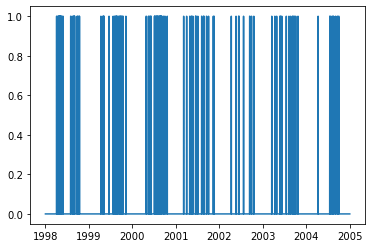

In [5]:
# plot the output variable
pyplot.plot(data.index, data.values[:,-1])
pyplot.show()

## 4. Choosing and Fitting Models
Convert time-series data to supervised. Evaluate Model by doing train-test split

(1803, 73) (730, 73)
Training Observations: 1803
Testing Observations: 730


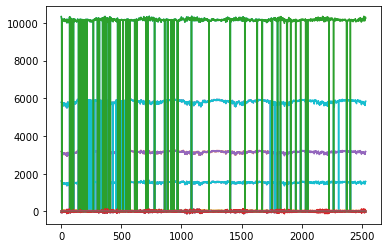

In [46]:
# replace missing observations with 0
values[values=='?'] = 0.0
# frame as supervised learning
supervised = list()
for i in range(len(values) - 1):
    X, y = values[i, :-1], values[i + 1, -1]
    row = hstack((X,y))
    supervised.append(row)
supervised = array(supervised)
# split into train-test
split = 365 * 2
train, test = supervised[:-split,:], supervised[-split:,:]
train, test = train.astype('float32'), test.astype('float32')
print(train.shape, test.shape)
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))
pyplot.plot(train)
pyplot.plot([i for i in train] + [x for x in test])
pyplot.show()
# save prepared datasets
savetxt('train.csv', train, delimiter=',')
savetxt('test.csv', test, delimiter=',')

## 5. Using and Evaluating a Forecasting Models
### Naive Prediction Model, BS, and BSS

With a brier score, lower is better (it is a loss function) with 0 being the best possible score. But with a brier skill score, higher is better with 1 (100%) being the best possible score.

In [7]:
# load datasets
train = loadtxt('train.csv', delimiter=',')
test = loadtxt('test.csv', delimiter=',')
# estimate naive probabilistic forecast
naive = sum(train[:,-1]) / train.shape[0]
print(naive)

0.07265668330560178


In [8]:
# forecast the test dataset
yhat = [naive for _ in range(len(test))]

In [9]:
# evaluate forecast
testy = test[:, -1]
bs = brier_score_loss(testy, yhat)
print('Brier Score: %.6f' % bs)

Brier Score: 0.039232


In [10]:
# calculate brier skill score
bs_ref = bs
bss = (bs - bs_ref) / (0 - bs_ref)
print('Brier Skill Score: %.6f' % bss)

Brier Skill Score: -0.000000


In [11]:
# split into inputs/outputs
trainX, trainy, testX, testy = train[:,:-1],train[:,-1],test[:,:-1],test[:,-1]

In [12]:
# estimate naive probabilistic forecast
naive = sum(train[:,-1]) / train.shape[0]
# forecast the test dataset
yhat = [naive for _ in range(len(test))]
# calculate naive bs
bs_ref = brier_score_loss(testy, yhat)

In [13]:
# evaluate a sklearn model
def evaluate_once(bs_ref, template, trainX, trainy, testX, testy):
    # fit model
    model = clone(template)
    model.fit(trainX, trainy)
    # predict probabilities for 0 and 1
    probs = model.predict_proba(testX)
    # keep the probabilities for class=1 only
    yhat = probs[:, 1]
    # calculate brier score
    bs = brier_score_loss(testy, yhat)
    # calculate brier skill score
    bss = (bs - bs_ref) / (0 - bs_ref)
    return bss

In [14]:
# evaluate an sklearn model n times
def evaluate(bs_ref, model, trainX, trainy, testX, testy, n=10):
    scores = [evaluate_once(bs_ref, model, trainX, trainy, testX, testy) for _ in range(n)]
    print('>%s, bss=%.6f' % (type(model), mean(scores)))
    return scores

In [15]:
# evaluate a suite of ensemble tree methods
scores, names = list(), list()
n_trees=100

### Ensemble Tree Prediction Models

The original paper reports some success with bagged decision trees. This is not surprising for a few reasons:
- Bagged decision trees do not require any data scaling.
- Bagged decision trees automatically perform a type of feature section, ignoring irrelevant features.
- Bagged decision trees predict reasonably calibrated probabilities (e.g. unlike SVM).

This suggests a good place to start when testing machine learning algorithms on the problem. Let's start by spot-checking the performance of a sample of standard ensemble tree methods:
- Bagged Decision Trees (BaggingClassifier)
- Extra Trees (ExtraTreesClassifier)
- Stochastic Gradient Boosting (GradientBoostingClassifier)
- Random Forest (RandomForestClassifier)

In [16]:
# bagging
model = BaggingClassifier(n_estimators=n_trees)
avg_bss = evaluate(bs_ref, model, trainX, trainy, testX, testy)
scores.append(avg_bss)
names.append('bagging')

><class 'sklearn.ensemble._bagging.BaggingClassifier'>, bss=0.059609


In [17]:
# extra
model = ExtraTreesClassifier(n_estimators=n_trees)
avg_bss = evaluate(bs_ref, model, trainX, trainy, testX, testy)
scores.append(avg_bss)
names.append('extra')

><class 'sklearn.ensemble._forest.ExtraTreesClassifier'>, bss=0.096661


In [18]:
# gbm
model = GradientBoostingClassifier(n_estimators=n_trees)
avg_bss = evaluate(bs_ref, model, trainX, trainy, testX, testy)
scores.append(avg_bss)
names.append('gbm')

><class 'sklearn.ensemble._gb.GradientBoostingClassifier'>, bss=0.120917


><class 'sklearn.ensemble._forest.RandomForestClassifier'>, bss=0.102038


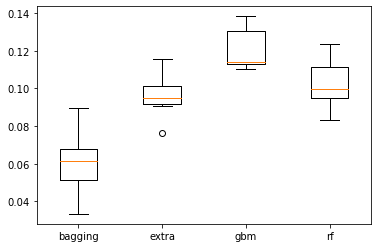

In [19]:
# rf
model = RandomForestClassifier(n_estimators=n_trees)
avg_bss = evaluate(bs_ref, model, trainX, trainy, testX, testy)
scores.append(avg_bss)
names.append('rf')
# plot results
pyplot.boxplot(scores, labels=names)
pyplot.show()

As we could see, Gradien Boosting Model are the most skillful. Now, let's we find out whether the performance of the model can be further lifted through some parameter tuning.

In [66]:
gbScores, gbNames = list(), list()
# base
model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, subsample=1.0, max_depth=3)
avg_bss = evaluate(bs_ref, model, trainX, trainy, testX, testy)
gbScores.append(avg_bss)
gbNames.append('base')

><class 'sklearn.ensemble._gb.GradientBoostingClassifier'>, bss=0.120024


In [67]:
# learning rate
model = GradientBoostingClassifier(learning_rate=0.01, n_estimators=500, subsample=1.0, max_depth=3)
avg_bss = evaluate(bs_ref, model, trainX, trainy, testX, testy)
gbScores.append(avg_bss)
gbNames.append('lr')

><class 'sklearn.ensemble._gb.GradientBoostingClassifier'>, bss=0.144642


In [68]:
# depth
model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, subsample=0.7, max_depth=7)
avg_bss = evaluate(bs_ref, model, trainX, trainy, testX, testy)
gbScores.append(avg_bss)
gbNames.append('depth')

><class 'sklearn.ensemble._gb.GradientBoostingClassifier'>, bss=0.097403


In [69]:
# all
model = GradientBoostingClassifier(learning_rate=0.01, n_estimators=500, subsample=0.7, max_depth=7)
avg_bss = evaluate(bs_ref, model, trainX, trainy, testX, testy)
gbScores.append(avg_bss)
gbNames.append('all')

><class 'sklearn.ensemble._gb.GradientBoostingClassifier'>, bss=0.199777


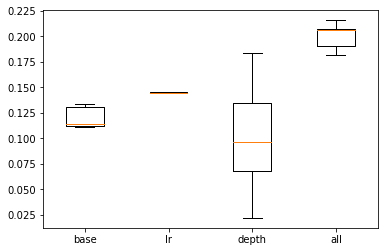

In [70]:
# plot results
pyplot.boxplot(gbScores, labels=gbNames)
pyplot.show()

In [71]:
print(gbScores)
print(gbNames)

[[0.13300039560423346, 0.11132711580554516, 0.12804312486949865, 0.13170756588278157, 0.111729778814519, 0.11143834748226027, 0.131953905082315, 0.11374886174644054, 0.11374001665607861, 0.11354741746649205], [0.1443738971443153, 0.14489649073449673, 0.14455303784965426, 0.1455494332372991, 0.14503572646175888, 0.14446565670099065, 0.14394040915186213, 0.14482792565967778, 0.14414185055852108, 0.14463222795311143], [0.1332054421045379, 0.09104324662396707, 0.13460329673760693, 0.18369140696456782, 0.10110236542201571, 0.13961507253348496, 0.021783699901663595, 0.06688160520514651, 0.07233439826200605, 0.02976473915683584], [0.1809817112626097, 0.20442686525802614, 0.20676560192953827, 0.18531110904465237, 0.20753676535073545, 0.20918698639750374, 0.19135537203332192, 0.21549334289857836, 0.18995047166061713, 0.20676188604101073]]
['base', 'lr', 'depth', 'all']


The results show that the ‘all’ modification/configuration that included each change resulted in the best mean BSS.

## Extension of the Previous Project

### Using ROC AUC as measure and implement xgboost

To contribute to the earlier example by Jason Brownlee. I accepted his challenge:
- Explore model evaluations that use ROC curve plots and ROC AUC measures
- Implement XGBoost

In [90]:
import numpy
from pandas import read_csv
from xgboost import XGBRegressor
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# load data
dataframe = read_csv("eighthr.data",header=None, index_col=0, parse_dates=True, squeeze=True)
dataset = dataframe.values
# split data into X and y
X = dataset[:,0:72]
Y = dataset[:,72]
# set missing values to 0
X[X == '?'] = 0.0
# convert to numeric
X = X.astype('float32')
# impute missing values as the mean
imputer = SimpleImputer()
imputed_x = imputer.fit_transform(X)
# encode Y class values as integers
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(Y)
label_encoded_y = label_encoder.transform(Y)
# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(imputed_x, label_encoded_y, test_size=test_size, random_state=seed)
# fit model
# model = LogisticRegression(solver='lbfgs')
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(X_train, y_train)
print(model)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
Accuracy: 93.43%


In [116]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

def evaluateRoc(model, X_train, y_train, X_test, y_test, ns_probs):
    model.fit(X_train, y_train)
    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    #calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()
    
    return lr_auc

# evaluate an sklearn model n times
# def evaluateRoc(model, trainX, trainy, testX, testy, ns_probs):
#     scores = [evaluateRocOnce(model, trainX, trainy, testX, testy, ns_probs) for _ in range(10)]
#     print('>%s, auc=%.6f' % (type(model), mean(scores)))
#     return scores

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.923


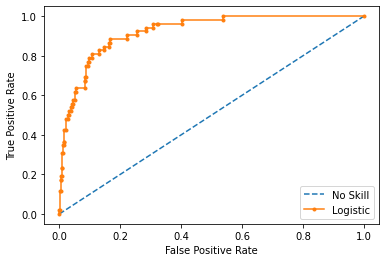

In [117]:
rocScores, rocModels = list(), list()
# base
model = XGBClassifier(learning_rate=0.1, n_estimators=100, subsample=1.0, max_depth=3, use_label_encoder=False, eval_metric='mlogloss')
score = evaluateRoc(model, X_train, y_train, X_test, y_test, ns_probs)
rocScores.append(score)
rocModels.append('base')

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.915


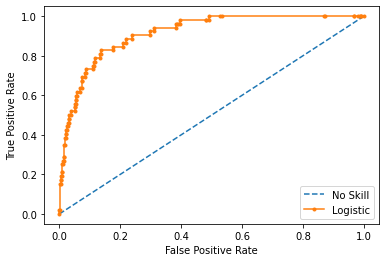

In [118]:
# learning rate
model = XGBClassifier(learning_rate=0.01, n_estimators=500, subsample=1.0, max_depth=3, use_label_encoder=False, eval_metric='mlogloss')
score = evaluateRoc(model, X_train, y_train, X_test, y_test, ns_probs)
rocScores.append(score)
rocModels.append('lr')

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.926


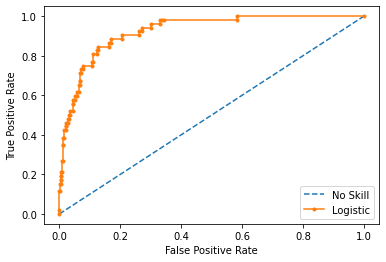

In [119]:
# depth
model = XGBClassifier(learning_rate=0.1, n_estimators=100, subsample=0.7, max_depth=7, use_label_encoder=False, eval_metric='mlogloss')
score = evaluateRoc(model, X_train, y_train, X_test, y_test, ns_probs)
rocScores.append(score)
rocModels.append('depth')

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.932


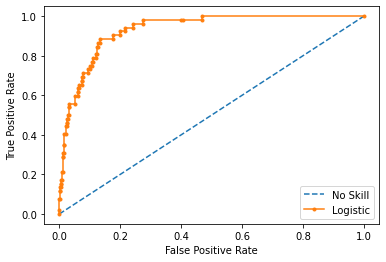

[0.9231014208721214, 0.914919157275845, 0.9257471827535522, 0.9324105830475258]
['base', 'lr', 'depth', 'all']


In [120]:
# all
model = XGBClassifier(learning_rate=0.01, n_estimators=500, subsample=0.7, max_depth=7, use_label_encoder=False, eval_metric='mlogloss')
score = evaluateRoc(model, X_train, y_train, X_test, y_test, ns_probs)
rocScores.append(score)
rocModels.append('all')
print(rocScores)
print(rocModels)

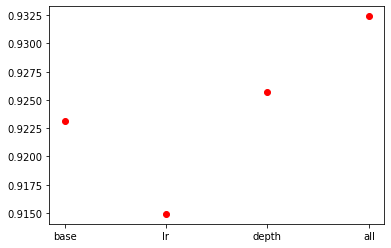

In [114]:
# plot results
pyplot.plot(rocModels, rocScores, 'ro')
# pyplot.show()